# Trying with using max over outputs

In [1]:
%load_ext autotime

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from keras.applications.densenet import DenseNet121
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import optimizers
from keras import metrics
from keras import models

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


from pathlib import Path
import pickle

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


time: 1.21 s


In [3]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

time: 653 ms


In [4]:
import utils # importing from our utils functions

time: 4.19 s


In [5]:
from utils.paralleldensenet121 import ParallelDenseNet121

time: 2.5 ms


In [6]:
from keras.layers import merge

time: 1.29 ms


In [7]:
num_parallel = 2

time: 809 µs


In [8]:
x_train, y_train, x_test, y_test = utils.read_mura_pickle()

INFO:utils.utils:loading data/MURA-v1.1/x_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl


time: 2.29 s


In [9]:
x_train = utils.normalize_pixels(x_train)
x_test = utils.normalize_pixels(x_test)

time: 4.6 s


In [10]:
x_train.shape

(36808, 256, 256)

time: 2.83 ms


In [11]:
size = x_train.shape[1]

time: 5.07 ms


In [12]:
with Path('./data/MURA-v1.1/train_groups.pkl').open('rb') as pkl_file:
    train_groups = pickle.load(pkl_file)
with Path('./data/MURA-v1.1/valid_groups.pkl').open('rb') as pkl_file:
    valid_groups = pickle.load(pkl_file)

time: 15.1 ms


In [13]:
train_img_count = train_groups.groupby(['body_part', 'patient_id', 'study_id'])['image_id'].max().reset_index()
train_enough_imgs = train_img_count[train_img_count.image_id.gt(1)].drop('image_id', axis=1)
train_groups_enough_imgs = pd.merge(
    train_enough_imgs.set_index(['body_part', 'patient_id', 'study_id']), 
         train_groups.reset_index().set_index(['body_part', 'patient_id', 'study_id']), left_index=True, right_index=True)

time: 98.6 ms


In [14]:
n_studies_train = train_groups_enough_imgs.groupby(['body_part', 'patient_id', 'study_id'])[0].count().count()
train_indices = train_groups_enough_imgs.reset_index().groupby(['body_part', 'patient_id', 'study_id'])['index'].min().reset_index().sort_values('index').reset_index(drop=True)
train_indices.head()

,body_part,patient_id,study_id,index
0,shoulder,1,1,0
1,shoulder,2,1,3
2,shoulder,3,1,6
3,shoulder,4,1,9
4,shoulder,6,1,14


time: 29.6 ms


In [15]:
valid_img_count = valid_groups.groupby(['body_part', 'patient_id', 'study_id'])['image_id'].max().reset_index()
valid_enough_imgs = valid_img_count[valid_img_count.image_id.gt(1)].drop('image_id', axis=1)
valid_groups_enough_imgs = pd.merge(
    valid_enough_imgs.set_index(['body_part', 'patient_id', 'study_id']), 
         valid_groups.reset_index().set_index(['body_part', 'patient_id', 'study_id']), left_index=True, right_index=True)

n_studies_valid = valid_groups_enough_imgs.groupby(['body_part', 'patient_id', 'study_id'])[0].count().count()
valid_indices = valid_groups_enough_imgs.reset_index().groupby(['body_part', 'patient_id', 'study_id'])['index'].min().reset_index().sort_values('index').reset_index(drop=True)
valid_indices.head()

,body_part,patient_id,study_id,index
0,wrist,11185,1,0
1,wrist,11186,1,4
2,wrist,11186,2,6
3,wrist,11186,3,9
4,wrist,11188,1,13


time: 32.8 ms


In [16]:
x_train_study = np.zeros(shape=(n_studies_train, size, size, num_parallel))
y_train_study = np.zeros(shape=(n_studies_train,))
x_valid_study = np.zeros(shape=(n_studies_valid, size, size, num_parallel))
y_valid_study = np.zeros(shape=(n_studies_valid,))

time: 1.98 ms


In [17]:
print(x_train_study.shape)
print(y_train_study.shape)
print(x_valid_study.shape)
print(y_valid_study.shape)

(12326, 256, 256, 2)
(12326,)
(1098, 256, 256, 2)
(1098,)
time: 1.64 ms


In [18]:
for i in range(n_studies_train):
    cur_index = train_indices.iloc[i]['index']
    if i < n_studies_train - 1:
        next_study_index = train_indices.iloc[i+1]['index']
    else:
        next_study_index = x_train.shape[0]
    for j in range(num_parallel):
        if cur_index < next_study_index:
            x_train_study[i, :, :, j] = x_train[cur_index, :, :]
            y_train_study[i] = y_train[cur_index]
        else:
            break
        cur_index = cur_index + 1

time: 8 s


In [19]:
for i in range(n_studies_valid):
    cur_index = valid_indices.iloc[i]['index']
    if i < n_studies_valid - 1:
        next_study_index = valid_indices.iloc[i+1]['index']
    else:
        next_study_index = x_test.shape[0]
    for j in range(num_parallel):
        if cur_index < next_study_index:
            x_valid_study[i, :, :, j] = x_test[cur_index, :, :]
            y_valid_study[i] = y_test[cur_index]
        else:
            break
        cur_index = cur_index + 1

time: 697 ms


In [20]:
del x_train, y_train, x_test, y_test
import gc; gc.collect()

140

time: 444 ms


Double checking if images are correct

1.0


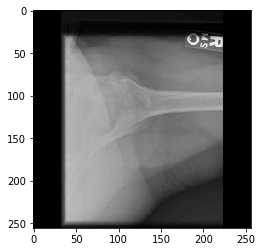

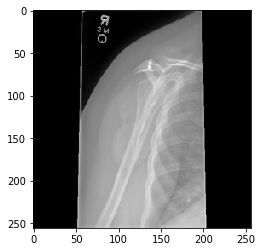

time: 207 ms


In [21]:
print(y_train_study[0])
for j in range(num_parallel):
    plt.imshow(x_train_study[0, :, :, j], cmap='gray')
    plt.show()

In [22]:
from sklearn.metrics import confusion_matrix

class MURAMetrics():
    
    def __init__(self, true_label, pred_label):
        assert true_label.shape[0] == pred_label.shape[0], (
            'true_label and pred_laben must have the same length!')
        self.y = true_label
        self.yhat = pred_label
        self.N = true_label.shape[0]
        self.cm = confusion_matrix(true_label, pred_label)
        
    def accuracy(self):
        return (self.cm[0, 0] + self.cm[1, 1]) / self.N

    def kappa(self):
        p_observed = self.accuracy()
        p_expected = (
            self.cm[1, :].sum() * self.cm[:, 1].sum() 
            + self.cm[0, :].sum() * self.cm[:, 0].sum()) / self.N**2
        return (p_observed - p_expected) / (1 - p_expected)
    
    def precision_and_recall(self):
        return {
            'precision': self.cm[1, 1] / self.cm[:, 1].sum(),
            'recall': self.cm[1, 1] / self.cm[1, :].sum()
        }

time: 4.45 ms


# Train Submodel

In [14]:
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[1, 1.2],
    fill_mode = 'constant',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True)

time: 4.05 ms


In [15]:
x_train = x_train.reshape(x_train.shape[0], size, size, 1)
x_test = x_test.reshape(x_test.shape[0], size, size, 1)

time: 2.65 ms


In [16]:
datagen.fit(x_train)

time: 4.25 s


In [38]:
starting_epoch = 345
train_round = 0
batch_size = 16
epochs_per_eval = 10
total_epochs = 445
history = {'loss': [], 'binary_accuracy': [], 'accuracy': [], 'kappa': [], 'precision': [], 'recall': []}

time: 3.58 ms


In [19]:
with tf.device('/GPU:1'):
    submodel = models.load_model('./trained_models/2_1_submodel_235.h5')

time: 33.9 s


In [39]:
with open('./trained_models/2_1_submodel_history.pkl', 'rb') as pkl_file:
    history = pickle.load(pkl_file)

time: 2.34 ms


In [ ]:
while (train_round+1) * epochs_per_eval + starting_epoch <= total_epochs:
    print(f'executing epochs {train_round * epochs_per_eval + 1 + starting_epoch}-{(train_round+1) * epochs_per_eval + starting_epoch}')
    
    # adam = optimizers.Adam()
    lr = 0.0001 * (0.9 ** train_round)
    sgd = optimizers.sgd(lr=lr, momentum=0.9, nesterov=True)
    submodel.compile(
        loss='binary_crossentropy',
        optimizer=sgd,
        metrics=[metrics.binary_accuracy])
    
    submodel.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch = len(x_train) / batch_size, epochs=epochs_per_eval, verbose=2)
    
    history['loss'].extend(submodel.history.history['loss'])
    history['binary_accuracy'].extend(submodel.history.history['binary_accuracy'])
    
    y_valid_hat = submodel.predict(x_test)
    true_label = np.round(y_test)
    pred_label = np.round(y_valid_hat)
    evaluate = MURAMetrics(true_label, pred_label)
    
    history['accuracy'].append(evaluate.accuracy())
    history['kappa'].append(evaluate.kappa())
    pnr = evaluate.precision_and_recall()
    history['precision'].append(pnr['precision'])
    history['recall'].append(pnr['recall'])
    
    print(f"Valid Accuracy: {history['accuracy'][-1]}")
    print(f"Valid Kappa: {history['kappa'][-1]}")
    print(f"Valid Precision: {history['precision'][-1]}")
    print(f"Valid Recall: {history['recall'][-1]}")
    
    cur_epoch = (train_round+1) * epochs_per_eval
    if cur_epoch % (epochs_per_eval * 10) == 0:
        print(f'Saving Model to trained_models/2_1_submodel_{cur_epoch + starting_epoch}.h5...')
        submodel.save(f'./trained_models/2_1_submodel_{cur_epoch + starting_epoch}.h5')
    
    print('Saving evaluation metrics history...')
    with open('./trained_models/2_1_submodel_history.pkl', 'wb') as pkl_file:
        pickle.dump(history, pkl_file)
    
    train_round += 1

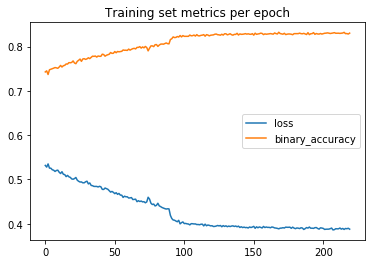

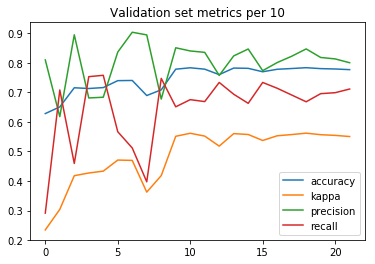

time: 332 ms


In [41]:
# Plots for epochs 145-365
# 145-235 used adam with default parameters
# 236-345 used lr = 0.001 * (0.9 ** train_round)
# 346-365 used lr = 0.0001 * (0.9 ** train_round) (pretty much levelled off, use 335 as result should be good enough)
train_metrics = ['loss', 'binary_accuracy']
validation_metrics = ['accuracy', 'kappa', 'precision', 'recall']
for metric in train_metrics:
    plt.plot(history[metric])
plt.title('Training set metrics per epoch')
plt.legend(train_metrics)
plt.show() 

for metric in validation_metrics:
    plt.plot(history[metric])
plt.title(f'Validation set metrics per {epochs_per_eval}')
plt.legend(validation_metrics)
plt.show() 

# Train combined model

In [23]:
sub_model = load_model('trained_models/2_1_submodel_335.h5')

time: 26.1 s


In [24]:
sub_model.layers[-1].activation = layers.activations.linear

time: 1.01 ms


In [ ]:
x_in = [layers.Input(shape=(256, 256, 1), name=f'imginput_{i}') for i in range(2)]

submodel_last_layer = models.Model(input=sub_model.input, output=sub_model.layers[-1].output)

sub = [None] * num_parallel

for j in range(num_parallel):
    with tf.device(f'/GPU:{j}'):
        sub[j] = submodel_last_layer(x_in[j])
        
parallel_dense = models.Model(input=x_in, output=layers.activations.sigmoid(layers.merge.average(sub)))

time: 26.1 ms


In [29]:
parallel_dense.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
imginput_0 (InputLayer)         (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
imginput_1 (InputLayer)         (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            7096769     imginput_0[0][0]                 
                                                                 imginput_1[0][0]                 
__________________________________________________________________________________________________
average_2 (Average)             (None, 1)            0           model_2[1][0]                    
          

Write image generator

In [33]:
def preprocess_images(images, datagen):
    X = np.zeros((len(images), images[0].shape[0], images[0].shape[1], 1))
    for i, image in enumerate(images):
        X[i, :, :, :] = datagen.random_transform(image)
    return X

def parallel_image_generator(input_x, input_y, batch_size, imgsize=256, num_inputs=4):
    datagen_args = dict(rotation_range=360,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=[1, 1.1],
        fill_mode = 'constant',
        cval=0,
        horizontal_flip=True,
        vertical_flip=True)
    datagens = [None] * num_inputs
    for j in range(num_inputs):
        datagens[j] = ImageDataGenerator(**datagen_args)
        
    X = [None] * num_inputs
    while True:
        # loop once per epoch
        num_recs = len(input_x)
        # indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            # loop once per batch
            batch_indices = np.random.random_integers(0, num_recs - 1, batch_size)# indices[bid * batch_size : (bid + 1) * batch_size]
            batch = [input_x[i, :, :, :] for i in batch_indices]
            # make sure image data generators generate same transformations
            for j in range(num_inputs):
                X[j] = preprocess_images(
                    [np.reshape(
                        b[:, :, j], (imgsize, imgsize, 1)) 
                     for b in batch], datagens[j])
            Y = np.array([input_y[i] for i in batch_indices])
            yield X, Y

time: 10.6 ms


In [34]:
starting_epoch = 0
train_round = 0
batch_size = 16
epochs_per_eval = 10
total_epochs = 250
history = {'loss': [], 'binary_accuracy': [], 'accuracy': [], 'kappa': [], 'precision': [], 'recall': []}

time: 2.71 ms


In [35]:
imgen = parallel_image_generator(x_train_study, y_train_study, batch_size=batch_size, num_inputs=num_parallel)

time: 1.61 ms


In [36]:
while (train_round+1) * epochs_per_eval + starting_epoch <= total_epochs:
    print(f'executing epochs {train_round * epochs_per_eval + 1 + starting_epoch}-{(train_round+1) * epochs_per_eval + starting_epoch}')
    
    adam = optimizers.Adam()
#     lr = 0.0001 * (0.9 ** train_round)
#     sgd = optimizers.sgd(lr=lr, momentum=0.9, nesterov=True)
    
    parallel_dense.compile(
        loss='binary_crossentropy',
        optimizer=adam,
        metrics=[metrics.binary_accuracy])
    
    parallel_dense.fit_generator(imgen, steps_per_epoch = len(x_train_study) / batch_size, epochs=epochs_per_eval, verbose=2)
    
    history['loss'].extend(parallel_dense.history.history['loss'])
    history['binary_accuracy'].extend(parallel_dense.history.history['binary_accuracy'])
    
    y_valid_hat = parallel_dense.predict([np.reshape(x_valid_study[:, :, :, j], (n_studies_valid, size, size, 1)) for j in range(num_parallel)])
    true_label = np.round(y_valid_study)
    pred_label = np.round(y_valid_hat)
    evaluate = MURAMetrics(true_label, pred_label)
    
    history['accuracy'].append(evaluate.accuracy())
    history['kappa'].append(evaluate.kappa())
    pnr = evaluate.precision_and_recall()
    history['precision'].append(pnr['precision'])
    history['recall'].append(pnr['recall'])
    
    print(f"Valid Accuracy: {history['accuracy'][-1]}")
    print(f"Valid Kappa: {history['kappa'][-1]}")
    print(f"Valid Precision: {history['precision'][-1]}")
    print(f"Valid Recall: {history['recall'][-1]}")
    
    cur_epoch = (train_round+1) * epochs_per_eval
    if cur_epoch % (epochs_per_eval * 10) == 0:
        print(f'Saving Model to trained_models/2_1_parallel_dense_{cur_epoch + starting_epoch}.h5...')
        submodel.save(f'./trained_models/2_1_parallel_dense_{cur_epoch + starting_epoch}.h5')
    
    print('Saving evaluation metrics history...')
    with open('./trained_models/2_1_parallel_dense_history.pkl', 'wb') as pkl_file:
        pickle.dump(history, pkl_file)
    
    train_round += 1

executing epochs 1-10
Epoch 1/10
 - 288s - loss: 0.7124 - binary_accuracy: 0.5730
Epoch 2/10
 - 245s - loss: 0.6818 - binary_accuracy: 0.5953
Epoch 3/10
 - 245s - loss: 0.6798 - binary_accuracy: 0.5965
Epoch 4/10
 - 245s - loss: 0.6745 - binary_accuracy: 0.6030
Epoch 5/10
 - 244s - loss: 0.6749 - binary_accuracy: 0.6042
Epoch 6/10
 - 244s - loss: 0.6738 - binary_accuracy: 0.6047
Epoch 7/10
 - 244s - loss: 0.6798 - binary_accuracy: 0.5888
Epoch 8/10
 - 243s - loss: 0.6720 - binary_accuracy: 0.6064
Epoch 9/10
 - 243s - loss: 0.6735 - binary_accuracy: 0.6021
Epoch 10/10
 - 244s - loss: 0.6719 - binary_accuracy: 0.6075
Valid Accuracy: 0.5300546448087432
Valid Kappa: -0.0018212746093099524
Valid Precision: 0.0
Valid Recall: 0.0
Saving evaluation metrics history...
executing epochs 11-20
Epoch 1/10
 - 283s - loss: 0.6756 - binary_accuracy: 0.5974
Epoch 2/10
 - 244s - loss: 0.6709 - binary_accuracy: 0.6069
Epoch 3/10
 - 245s - loss: 0.6731 - binary_accuracy: 0.6013
Epoch 4/10
 - 245s - loss: 

NameError: name 'submodel' is not defined

time: 7h 10min 39s


# Diagnose

In [34]:
X, Y = imgen.__next__()

time: 201 ms


In [35]:
Y

array([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.])

time: 2.57 ms


In [36]:
X[1].shape

(16, 256, 256, 1)

time: 2.2 ms


In [37]:
X[0][0, :, :, 0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

time: 4.09 ms


In [38]:
i=0

time: 1.11 ms


In [39]:
Y[i]

1.0

time: 5.8 ms


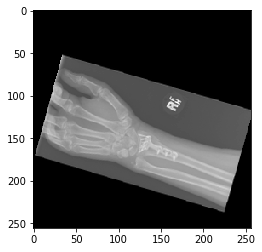

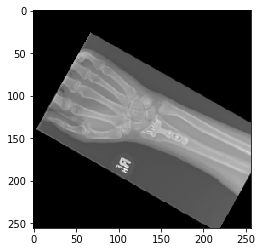

time: 318 ms


In [40]:
for j in range(num_parallel):
    plt.imshow(X[j][i, :, :, 0], cmap='gray')
    plt.show()

In [45]:
parallel_dense.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
imginput_0 (InputLayer)         (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
imginput_1 (InputLayer)         (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            7096769     imginput_0[0][0]                 
                                                                 imginput_1[0][0]                 
__________________________________________________________________________________________________
average_1 (Average)             (None, 1)            0           model_1[1][0]                    
          

In [56]:
llyr = parallel_dense.get_layer('model_1')

time: 1.33 ms


In [58]:
llyr.outputs

[<tf.Tensor 'dense_3/Sigmoid:0' shape=(?, 1) dtype=float32>]

time: 3.9 ms


In [67]:
[parallel_dense.get_layer('model_1').predict(X[0]), parallel_dense.get_layer('model_1').predict(X[1])]

[array([[0.37669477],
        [0.34713903],
        [0.360646  ],
        [0.38409138],
        [0.35270178],
        [0.34227717],
        [0.37548903],
        [0.35813764],
        [0.3989523 ],
        [0.37248597],
        [0.37319106],
        [0.33258897],
        [0.36997783],
        [0.4386978 ],
        [0.3916164 ],
        [0.36255652]], dtype=float32), array([[0.37901717],
        [0.20903136],
        [0.37083808],
        [0.37227738],
        [0.36047667],
        [0.35041556],
        [0.46060336],
        [0.36085728],
        [0.4083379 ],
        [0.36044058],
        [0.37170643],
        [0.36213607],
        [0.392097  ],
        [0.22353627],
        [0.36380914],
        [0.35951924]], dtype=float32)]

time: 189 ms


In [68]:
Y

array([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.])

time: 3.76 ms


In [61]:
mid_layer = models.Model(input=parallel_dense.input, output=parallel_dense.get_layer('dense_3').get_output_at(j) for j in range(num_parallel)])
mid_out = mid_layer.predict(X)
mid_out[0].shape

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_2:0", shape=(?, 256, 256, 1), dtype=float32) at layer "input_2". The following previous layers were accessed without issue: []

time: 38.4 ms


In [ ]:
mid_out

In [58]:
mid_layer = models.Model(input=parallel_dense.input, output=[parallel_dense.get_layer('dense_3').get_output_at(j) for j in range(num_parallel)])
mid_out = mid_layer.predict(X)
mid_out[0].shape

(40, 128, 128, 64)

time: 5.52 s


In [ ]:
for j in range(num_parallel):
    fig, axes = plt.subplots(8, 8)
    fig.set_size_inches(10, 10)
    for k in range(64):
        axes[k//8, k-(k//8)*8].imshow(mid_out[j][0, :, :, k], cmap='gray')
    plt.show()

In [63]:
mid_layer = models.Model(input=parallel_dense.input, output=[parallel_dense.get_layer('batch_normalization_4').get_output_at(j) for j in range(num_parallel)])
mid_out = mid_layer.predict(X)
mid_out[0].shape

(40, 64, 64, 64)

time: 5.4 s


In [ ]:
for j in range(num_parallel):
    fig, axes = plt.subplots(8, 8)
    fig.set_size_inches(10, 10)
    for k in range(64):
        axes[k//8, k-(k//8)*8].imshow(mid_out[j][0, :, :, k], cmap='gray')
    plt.show()

In [65]:
mid_layer = models.Model(input=parallel_dense.input, output=[parallel_dense.get_layer('conv2d_87').get_output_at(j) for j in range(num_parallel)])
mid_out = mid_layer.predict(X)
mid_out[0].shape

(40, 16, 16, 32)

time: 7.45 s


In [ ]:
for j in range(num_parallel):
    fig, axes = plt.subplots(4, 8)
    fig.set_size_inches(10, 5)
    for k in range(32):
        axes[k//8, k-(k//8)*8].imshow(mid_out[j][0, :, :, k], cmap='gray')
    plt.show()

In [94]:
for j in range(num_parallel):
    plt.imshow(X[j][i, :, :, 0], cmap='gray')
    plt.show()

(20, 8, 8, 64)

time: 1min 24s


In [ ]:
for j in range(4):
    fig, axes = plt.subplots(8, 8)
    fig.set_size_inches(10, 10)
    for k in range(64):
        axes[k//8, k-(k//8)*8].imshow(mid_out[j][0, :, :, k], cmap='gray')
    plt.show()

In [66]:
del llyr; gc.collect()

846031

time: 5.32 s


In [42]:
Y_hat = parallel_dense.predict(X)

time: 6.07 s


In [43]:
Y_hat

array([[0.37785596],
       [0.2780852 ],
       [0.36574203],
       [0.37818438],
       [0.35658923],
       [0.34634638],
       [0.41804618],
       [0.35949746],
       [0.4036451 ],
       [0.36646327],
       [0.37244874],
       [0.34736252],
       [0.3810374 ],
       [0.33111703],
       [0.3777128 ],
       [0.36103788]], dtype=float32)

time: 3.72 ms


In [44]:
Y

array([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.])

time: 3.7 ms


In [ ]:
parallel_dense.summary()

In [92]:
X, Y = datagen.flow(x_train, y_train, batch_size=batch_size).__next__()

time: 95.3 ms


In [93]:
Y_hat = submodel.predict(X)

time: 2min 10s


In [94]:
Y_hat

array([[4.50249910e-01],
       [4.11489427e-01],
       [4.51364875e-01],
       [4.75237966e-01],
       [4.68280166e-01],
       [4.45379734e-01],
       [4.56905723e-01],
       [5.21016598e-01],
       [3.48092943e-01],
       [4.14206177e-01],
       [4.29860085e-01],
       [4.67342854e-01],
       [4.61505890e-01],
       [4.68058079e-01],
       [1.00747635e-33],
       [4.71889734e-01]], dtype=float32)

time: 4.3 ms


In [95]:
Y

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1])

time: 3.62 ms


In [96]:
plot_model(submodel, 'submodel.png')

time: 2.89 s
